# Task 3: Predicting Paddy Plant Age from Images

## Project Overview
This notebook implements a deep learning model to predict the age of paddy plants based on their images. This is an important agricultural application that can help farmers monitor crop growth and optimize harvesting times.

### Key Features:
- Uses EfficientNet-B0 architecture with custom regression head
- Incorporates metadata (plant variety, label) and Green-Red Vegetation Index (GRVI)
- Implements data preprocessing and augmentation techniques
- Evaluates model performance using multiple metrics (MSE, RMSE, MAE, R²)


## Model Architecture: EfficientNet-B0
We use EfficientNet-B0 as our base model due to its excellent performance-to-parameter ratio. The model has been modified with a custom regression head to predict plant age in days.


## Library Imports and Setup
We'll start by importing all necessary libraries for data manipulation, visualization, image processing, and deep learning.


In [1]:
# Import Libraries
# Data manipulation and analysis
import pandas as pd  # For dataframe operations
import numpy as np   # For numerical operations

# Visualization
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns            # For enhanced visualizations

# System and file operations
import os       # For file path operations
import hashlib  # For calculating file hashes
from collections import defaultdict  # For efficient hash storage
from PIL import Image               # For image loading and manipulation

# Scikit-Learn Imports
from sklearn.model_selection import train_test_split  # For splitting dataset
from sklearn.metrics import (
    mean_absolute_error,    # MAE metric
    mean_squared_error,     # MSE metric
    root_mean_squared_error,# RMSE metric
    r2_score                # R² coefficient of determination
)

# PyTorch Imports
import torch                                  # Base PyTorch
import torch.nn as nn                         # Neural network modules
from torch.utils.data import Dataset, DataLoader  # Dataset handling
import torchvision.transforms as transforms   # Image transformations
import torchvision.models as models           # Pretrained models

from task3_EfNetB0_predict.task3_efNetb0 import image_directory


## Data Loading
In this section, we load the metadata for our paddy plant images and perform exploratory data analysis to understand the dataset characteristics. The metadata contains information about each image, including the plant's age (our target variable), variety, and other attributes.


In [ ]:
# Mount Google Drive to access files
from google.colab import drive
import gdown
drive.mount('/content/drive')

# Google Drive file ID for the training images dataset
file_id = "1ilTxsQCB8pOVCgrZlDRiM0Xzw1bNN4pi"  # ID for train_images.zip
file_name = "train_images.zip"
file_path = "/content/" + file_name

# Download the training images dataset from Google Drive
# This uses gdown to download the file using its Google Drive ID
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)


In [ ]:
!unzip -q $file_path -d /content/extracted_folder

In [ ]:
# Google Drive file ID for the metadata CSV
meta_file_id = "1eXFd6XBjgESjXV8BksAWWmttzqh3V62X"  # ID for meta_train.csv
meta_file_name = "meta_train.csv"
meta_file_path = "/content/" + meta_file_name

# Download the metadata CSV file
gdown.download(f"https://drive.google.com/uc?id={meta_file_id}", meta_file_path, quiet=False)


In [2]:
# Load the metadata CSV file containing information about paddy plant images
meta_df = pd.read_csv(meta_file_path)

# Display the first 5 rows to get a quick overview of the data structure
meta_df.head()  # Shows image_id, age, variety, and label columns


,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


## Data Preprocessing and Dataset Creation

### Setting Random Seeds
First, we set random seeds for reproducibility across all libraries (NumPy, PyTorch, CUDA).

### Custom Dataset Class
We create a custom PyTorch Dataset class (`PaddyAgeDataset`) that:
- Loads paddy plant images and their corresponding age labels
- Computes the Green-Red Vegetation Index (GRVI) as an additional feature
  - GRVI = (Green - Red) / (Green + Red), which helps identify plant health and growth stage
- Applies image transformations (resizing, normalization, augmentation)
- Encodes categorical variables (plant variety and label) as one-hot vectors
- Returns processed images and metadata for model training

### Data Augmentation
For the training set, we apply several augmentation techniques:
- Random cropping
- Horizontal flipping
- Color jittering (brightness and contrast adjustments)

These augmentations help improve model generalization by creating variations of the training images.

In [8]:
# Set random seeds for reproducibility across runs
seed = 42  # Choose a fixed seed value

# Set NumPy random seed
np.random.seed(seed)  # Controls numpy's random number generation

# Set PyTorch random seeds
torch.manual_seed(seed)  # Controls PyTorch CPU random number generation
torch.cuda.manual_seed_all(seed)  # Controls PyTorch GPU random number generation on all devices

# Additional settings for complete reproducibility
torch.backends.cudnn.deterministic = True  # Ensures that CUDA selects deterministic algorithms
torch.backends.cudnn.benchmark = False     # Disables CUDA auto-tuner which can introduce randomness

In [9]:
class PaddyAgeDataset(Dataset):
    """
    Custom PyTorch Dataset for paddy plant age prediction.

    This dataset loads paddy plant images, computes the Green-Red Vegetation Index (GRVI),
    and prepares both image data and metadata (plant variety, label) for model training.

    Attributes:
        df (DataFrame): Pandas DataFrame containing image metadata
        image_dir (str): Directory containing the image files
        transform (callable): PyTorch transforms to apply to images
        label_map (dict): Mapping from label names to indices
        variety_map (dict): Mapping from variety names to indices
    """
    def __init__(self, dataframe, image_dir, transform=None, label_map=None, variety_map=None):
        """
        Initialize the dataset with image metadata and paths.

        Args:
            dataframe (DataFrame): Pandas DataFrame with image metadata
            image_dir (str): Root directory containing image files
            transform (callable, optional): Transforms to apply to images
            label_map (dict, optional): Mapping from label names to indices
            variety_map (dict, optional): Mapping from variety names to indices
        """
        self.df = dataframe.reset_index(drop=True)  # Reset index for consistent indexing
        self.image_dir = image_dir                  # Root directory for images
        self.transform = transform                  # Image transformations
        self.label_map = label_map                  # Label → index mapping
        self.variety_map = variety_map              # Variety → index mapping

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.df)

    @staticmethod
    def compute_grvi(tensor):
        """
        Compute Green-Red Vegetation Index (GRVI) from an RGB image tensor.

        GRVI = (Green - Red) / (Green + Red)
        This index helps identify plant health and growth stage.

        Args:
            tensor (Tensor): RGB image tensor with shape [3, H, W]

        Returns:
            Tensor: GRVI map with shape [H, W]
        """
        r, g, b = tensor[0], tensor[1], tensor[2]  # Extract RGB channels
        grvi = (g - r) / (g + r + 1e-6)  # Add small epsilon to prevent division by zero
        return grvi  # Return GRVI map

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve

        Returns:
            tuple: (image, age_label, label_onehot, variety_onehot, grvi_mean)
                - image: Normalized RGB image tensor
                - age_label: Plant age in days (float)
                - label_onehot: One-hot encoded label
                - variety_onehot: One-hot encoded variety
                - grvi_mean: Mean GRVI value for the image
        """
        # Get metadata for this sample
        row = self.df.loc[idx]

        # Construct full path to image file
        image_path = os.path.join(self.image_dir, row['label'], row['image_id'])

        # Load image and convert to RGB
        image = Image.open(image_path).convert("RGB")

        # Apply transforms (converts to tensor but doesn't normalize yet)
        image = self.transform(image)  # shape [3, H, W]

        # Compute GRVI map from the unnormalized tensor
        grvi_map = self.compute_grvi(image)  # shape [H, W]

        # Calculate mean GRVI value across the image
        # Convert to scalar tensor with shape [1]
        grvi_mean = torch.tensor(grvi_map.mean().item(), dtype=torch.float32).unsqueeze(0)

        # Normalize image AFTER computing GRVI (using ImageNet mean/std)
        mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]  # Reshape for broadcasting
        std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]   # Reshape for broadcasting
        image = (image - mean) / std  # Apply normalization

        # Convert age to tensor (our regression target)
        label = torch.tensor(float(row['age']), dtype=torch.float32)

        # Create one-hot encoded vectors for categorical features
        label_onehot = torch.zeros(len(self.label_map))
        variety_onehot = torch.zeros(len(self.variety_map))

        # Set the appropriate indices to 1.0
        label_onehot[self.label_map[row["label"]]] = 1.0
        variety_onehot[self.variety_map[row["variety"]]] = 1.0

        # Return all features and target
        return image, label, label_onehot, variety_onehot, grvi_mean


In [10]:
# Step 1: Split data into training and validation sets
# - test_size=0.2: Use 20% of data for validation
# - random_state=42: Ensure reproducible splits
# - stratify: Maintain same label distribution in both sets
train_df, val_df = train_test_split(
    meta_df,
    test_size=0.2,
    random_state=42,
    stratify=meta_df['label']  # Ensure balanced distribution of plant types
)

# Step 2: Create mappings for categorical variables to indices
# These maps convert categorical variables to numerical indices for one-hot encoding
label_map = {label: i for i, label in enumerate(meta_df['label'].unique())}  # Map each label to an index
variety_map = {var: i for i, var in enumerate(meta_df['variety'].unique())}  # Map each variety to an index

# Step 3: Define image transformations for training and validation sets
# Training transforms include data augmentation to improve model generalization
train_transforms = transforms.Compose([
    # Random crop with resizing to 224x224 pixels (standard input size for EfficientNet)
    # scale parameter allows crops between 80-100% of original image
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    # Randomly flip images horizontally with 50% probability
    transforms.RandomHorizontalFlip(p=0.5),

    # Randomly adjust brightness and contrast to simulate different lighting conditions
    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    # Convert PIL image to PyTorch tensor (scales pixels from [0, 255] to [0, 1])
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std (helps model converge faster)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # RGB means from ImageNet
        std=[0.229, 0.224, 0.225]    # RGB standard deviations from ImageNet
    )
])

# Validation transforms - no augmentation, just resize and normalize
val_transforms = transforms.Compose([
    # Simple resize to 224x224 pixels without random cropping
    transforms.Resize((224, 224)),

    # Convert to tensor
    transforms.ToTensor(),

    # Apply same normalization as training for consistency
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # RGB means from ImageNet
        std=[0.229, 0.224, 0.225]    # RGB standard deviations from ImageNet
    )
])

# Step 4: Create dataset objects for training and validation
# Training dataset with augmentation
image_directory = "/content/extracted_folder/train_images"
train_dataset = PaddyAgeDataset(
    dataframe=train_df,
    image_dir=image_directory,
    transform=train_transforms,  # Apply training transforms with augmentation
    label_map=label_map,
    variety_map=variety_map
)

# Validation dataset without augmentation
val_dataset = PaddyAgeDataset(
    dataframe=val_df,
    image_dir=image_directory,
    transform=val_transforms,  # Apply validation transforms (no augmentation)
    label_map=label_map,
    variety_map=variety_map
)

In [11]:
# Create DataLoaders for efficient batch processing
# Training loader with shuffling to prevent the model from learning the order of samples
train_loader = DataLoader(
    train_dataset,
    batch_size=32,     # Process 32 images at once
    shuffle=True       # Shuffle data to prevent order-based learning
)

# Validation loader without shuffling (order doesn't matter for evaluation)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,     # Same batch size as training for consistency
    shuffle=False      # No need to shuffle validation data
)


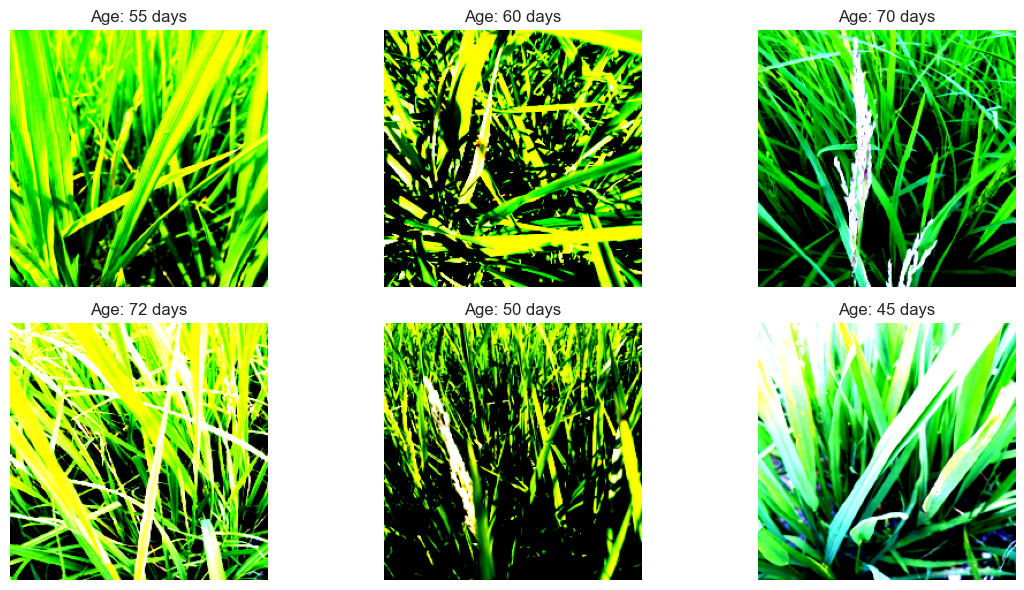

In [12]:
def denormalize(img_tensor):
    """
    Reverse the normalization applied to image tensors for visualization.

    This function converts normalized tensors back to their original scale
    so they can be properly displayed as images.

    Args:
        img_tensor (Tensor): Normalized image tensor with shape [C, H, W]
                            where C can be 3 (RGB) or more channels

    Returns:
        Tensor: Denormalized image tensor with same shape as input
    """
    # Create a copy of the input tensor to avoid modifying the original
    denorm = img_tensor.clone()

    # Only apply denormalization to the first 3 channels (RGB)
    # The 4th channel might be GRVI which doesn't need denormalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # ImageNet means reshaped for broadcasting
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)   # ImageNet std reshaped for broadcasting

    # Reverse the normalization: x = (normalized * std) + mean
    denorm[:3] = denorm[:3] * std + mean  # Only apply to RGB channels

    return denorm

# Visualize sample images from the training set
# Get one batch of data from the training loader
images, ages, _, _, _ = next(iter(train_loader))  # Unpack only images and ages, ignore one-hot vectors and GRVI

# Create a figure to display 6 sample images in a 2x3 grid
plt.figure(figsize=(12, 6))  # Set figure size (width, height) in inches

# Loop through the first 6 images in the batch
for i in range(6):
    # Create a subplot in a 2x3 grid
    plt.subplot(2, 3, i + 1)

    # Process the image for display:
    # 1. Denormalize to convert from normalized tensor to original scale
    # 2. Permute from [C,H,W] to [H,W,C] format for matplotlib
    # 3. Convert to numpy array for matplotlib
    img = denormalize(images[i]).permute(1, 2, 0).numpy()

    # Clip pixel values to [0,1] range to ensure proper display
    img = np.clip(img, 0, 1)

    # Display the image
    plt.imshow(img)

    # Add a title showing the plant's age
    plt.title(f"Age: {ages[i]:.0f} days")

    # Hide axis ticks and labels
    plt.axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure with all subplots
plt.show()

## Model Architecture

### EfficientNet-B0 with Custom Regression Head
We implement a custom neural network model for age regression:

1. **Base Model**: EfficientNet-B0
   - A lightweight but powerful CNN architecture
   - Known for its excellent efficiency-to-performance ratio
   - We remove the original classification head

2. **Feature Fusion**:
   - We combine the visual features from EfficientNet (1280-dimensional vector)
   - With metadata features:
     - One-hot encoded plant variety
     - One-hot encoded label
     - GRVI (Green-Red Vegetation Index) scalar

3. **Regression Head**:
   - Multi-layer perceptron with batch normalization and dropout
   - Layer 1: 1280+metadata → 512 neurons
   - Layer 2: 512 → 256 neurons
   - Output Layer: 256 → 1 (age prediction)

This architecture allows the model to learn from both visual features and important metadata, potentially improving prediction accuracy.

In [13]:
class AgeRegressor(nn.Module):
    """
    Custom neural network model for paddy plant age regression.

    This model combines EfficientNet-B0 for image feature extraction with
    metadata features (plant variety, label, GRVI) for improved prediction accuracy.

    Attributes:
        base (nn.Module): EfficientNet-B0 base model for feature extraction
        metadata_dim (int): Total dimension of metadata features
        head (nn.Sequential): MLP regression head for age prediction
    """
    def __init__(self, num_labels, num_varieties):
        """
        Initialize the age regression model.

        Args:
            num_labels (int): Number of unique plant labels for one-hot encoding
            num_varieties (int): Number of unique plant varieties for one-hot encoding
        """
        super().__init__()

        # Initialize EfficientNet-B0 as the base model
        self.base = models.efficientnet_b0(weights=None)  # No pretrained weights
        self.base.classifier = nn.Identity()  # Remove the original classification head

        # Calculate total metadata dimension (label + variety + GRVI)
        self.metadata_dim = num_labels + num_varieties + 1  # +1 for GRVI scalar

        # Create a multi-layer regression head
        self.head = nn.Sequential(
            # First layer: Combine EfficientNet features (1280) with metadata
            nn.Linear(1280 + self.metadata_dim, 512),  # Input: combined features
            nn.BatchNorm1d(512),  # Normalize activations for faster training
            nn.ReLU(),            # Non-linearity
            nn.Dropout(0.3),      # Prevent overfitting with 30% dropout

            # Second layer: Further reduce dimensionality
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # Activation function
            nn.Dropout(0.2),      # 20% dropout (less than first layer)

            # Output layer: Single neuron for age regression
            nn.Linear(256, 1)     # Output: predicted age (scalar)
        )

    def forward(self, x, label_vec, variety_vec, grvi_scalar):
        """
        Forward pass through the network.

        Args:
            x (Tensor): Batch of images, shape [batch_size, 3, 224, 224]
            label_vec (Tensor): One-hot encoded labels, shape [batch_size, num_labels]
            variety_vec (Tensor): One-hot encoded varieties, shape [batch_size, num_varieties]
            grvi_scalar (Tensor): GRVI values, shape [batch_size, 1]

        Returns:
            Tensor: Predicted ages, shape [batch_size, 1]
        """
        # Extract visual features from images using EfficientNet
        features = self.base(x)  # Shape: [batch_size, 1280]

        # Combine all metadata features
        meta = torch.cat([label_vec, variety_vec, grvi_scalar], dim=1)  # Concatenate along feature dimension

        # Combine visual features with metadata
        combined = torch.cat([features, meta], dim=1)  # Shape: [batch_size, 1280 + metadata_dim]

        # Pass through regression head to get age predictions
        return self.head(combined)  # Shape: [batch_size, 1]

## Training Setup

### Hardware and Initialization
- We use GPU acceleration if available, falling back to CPU if not
- Initialize the model with the correct number of label and variety classes

### Optimization Strategy
- **Loss Function**: Mean Squared Error (MSE)
  - Appropriate for regression tasks like age prediction
  - Penalizes larger errors more heavily than smaller ones

- **Optimizer**: Adam
  - Adaptive learning rate optimization algorithm
  - Initial learning rate: 1e-4
  - Efficiently handles sparse gradients and noisy data

- **Learning Rate Scheduler**: ReduceLROnPlateau
  - Reduces learning rate when validation loss plateaus
  - Patience: 3 epochs (waits 3 epochs before reducing)
  - Reduction factor: 0.5 (halves the learning rate)
  - Minimum learning rate: 1e-6 (prevents too small values)

This combination of optimization techniques helps the model converge more effectively while avoiding local minima.

In [14]:
# Set up the computation device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Calculate dimensions for categorical features
num_labels = len(label_map)       # Number of unique plant labels (e.g., BroadLeaf, Narrow)
num_varieties = len(variety_map)  # Number of unique plant varieties (e.g., ADT, CR1009)
print(f"Number of labels: {num_labels}, Number of varieties: {num_varieties}")

# Initialize our custom model and move it to the selected device
model = AgeRegressor(
    num_labels=num_labels,      # Pass number of labels for one-hot dimension
    num_varieties=num_varieties # Pass number of varieties for one-hot dimension
).to(device)  # Move model to GPU if available

# Define loss function: Mean Squared Error
# MSE is appropriate for regression tasks as it penalizes larger errors more heavily
criterion = nn.MSELoss()

# Define optimizer: Adam with learning rate 1e-4
# Adam combines the benefits of AdaGrad and RMSProp and works well for most deep learning tasks
optimizer = torch.optim.Adam(
    model.parameters(),  # Optimize all model parameters
    lr=1e-4             # Initial learning rate
)

# Learning rate scheduler: ReduceLROnPlateau
# This reduces the learning rate when validation loss stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,       # The optimizer whose learning rate will be adjusted
    mode='min',      # Reduce LR when monitored value stops decreasing
    factor=0.5,      # Multiply learning rate by this factor (i.e., halve it)
    patience=3,      # Number of epochs with no improvement after which LR will be reduced
    min_lr=1e-6      # Lower bound on the learning rate
)


Using device: cuda
Number of labels: 10, Number of varieties: 10


## Model Training Process

### Training Configuration
- **Maximum Epochs**: 150
- **Batch Size**: 32 (defined in DataLoader)
- **Early Stopping**: Patience of 5 epochs
- **Performance Metrics**: MSE, RMSE, R², MAE

### Training Loop
For each epoch, we:

1. **Training Phase**:
   - Set model to training mode
   - Forward pass: Generate predictions
   - Calculate MSE loss
   - Backward pass: Compute gradients
   - Update weights using Adam optimizer
   - Track training loss

2. **Validation Phase**:
   - Set model to evaluation mode (disables dropout, etc.)
   - Generate predictions on validation set
   - Calculate validation loss and metrics
   - Update learning rate scheduler

3. **Early Stopping Check**:
   - Track best validation loss
   - If validation loss doesn't improve for 5 consecutive epochs, stop training
   - This prevents overfitting and saves training time

4. **Metrics Tracking**:
   - Record MSE, RMSE, R², and MAE for each epoch
   - These metrics will be visualized after training

This comprehensive training approach ensures efficient model convergence while monitoring multiple performance indicators.

In [15]:
# Training Loop Implementation
# Define maximum number of training epochs
num_epochs = 150

# Initialize lists to store metrics for each epoch
# These will be used for visualization and analysis after training
train_losses, val_losses = [], []  # Training and validation losses
mse_vals, rmse_vals = [], []       # Mean Squared Error and Root Mean Squared Error
r2_vals, mae_vals = [], []         # R² coefficient and Mean Absolute Error

# Early stopping setup
best_val_loss = float('inf')       # Initialize the best validation loss to infinity
counter = 0                        # Counter for epochs without improvement
early_stopping_patience = 5        # Number of epochs to wait before stopping

# Print training start message
print("Ping!")  # Simple indicator that training is about to start
print(f"Training started for {num_epochs} epochs.")

# Main training loop - iterate through each epoch
for epoch in range(num_epochs):
    # Set model to training mode (enables dropout, batch normalization, etc.)
    model.train()
    running_loss = 0  # Initialize loss accumulator for this epoch

    # Iterate through mini-batches from the training data loader
    for images, labels, label_vecs, variety_vecs, grvi_scalars in train_loader:
        # Move all tensors to the appropriate device (GPU if available)
        images = images.to(device)                      # Image data
        labels = labels.to(device).unsqueeze(1)         # Add dimension to match model output shape [batch_size, 1]
        label_vecs = label_vecs.to(device)              # One-hot encoded labels
        variety_vecs = variety_vecs.to(device)          # One-hot encoded varieties
        grvi_scalars = grvi_scalars.to(device)          # GRVI values

        # Reset gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass: compute predictions
        preds = model(images, label_vecs, variety_vecs, grvi_scalars)

        # Calculate loss between predictions and ground truth
        loss = criterion(preds, labels)

        # Backward pass: compute gradients
        loss.backward()

        # Update weights based on computed gradients
        optimizer.step()

        # Accumulate batch loss (convert tensor to Python scalar with .item())
        running_loss += loss.item()

    # Calculate average training loss for this epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store for later visualization

    ## Validation Phase
    # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
    model.eval()

    # Initialize lists to store predictions and ground truth values
    val_preds, val_true = [], []
    val_loss = 0  # Initialize validation loss accumulator

    # Disable gradient calculation for validation (saves memory and speeds up computation)
    with torch.no_grad():
        # Iterate through mini-batches from the validation data loader
        for images, labels, label_vecs, variety_vecs, grvi_scalars in val_loader:
            # Move all tensors to the appropriate device (GPU if available)
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # Ensure labels have shape [batch_size, 1]
            label_vecs = label_vecs.to(device)
            variety_vecs = variety_vecs.to(device)
            grvi_scalars = grvi_scalars.to(device)

            # Forward pass: compute predictions
            preds = model(images, label_vecs, variety_vecs, grvi_scalars)

            # Calculate loss between predictions and ground truth
            loss = criterion(preds, labels)

            # Accumulate batch loss
            val_loss += loss.item()

            # Store predictions and ground truth for metric calculation
            # Move tensors to CPU and convert to NumPy arrays for sklearn metrics
            val_preds.extend(preds.cpu().squeeze().numpy())  # Convert predictions to 1D array
            val_true.extend(labels.cpu().squeeze().numpy())  # Convert labels to 1D array

    # Calculate average validation loss for this epoch
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)  # Store for later visualization

    # Update learning rate scheduler based on validation loss
    # This will reduce the learning rate when validation loss plateaus
    scheduler.step(val_loss)

    # Calculate and store evaluation metrics
    # Mean Squared Error - average of squared differences between predictions and true values
    mse = mean_squared_error(val_true, val_preds)
    mse_vals.append(mse)

    # Root Mean Squared Error - square root of MSE, in same units as target variable
    rmse = root_mean_squared_error(val_true, val_preds)
    rmse_vals.append(rmse)

    # R² Score - proportion of variance in dependent variable predictable from independent variables
    # 1.0 is perfect prediction, 0.0 means model predicts mean of data
    r2 = r2_score(val_true, val_preds)
    r2_vals.append(r2)

    # Mean Absolute Error - average of absolute differences between predictions and true values
    mae = mean_absolute_error(val_true, val_preds)
    mae_vals.append(mae)

    # Print current learning rate and metrics for this epoch
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f} | MAE: {mae:.4f}")

    # Early stopping logic
    # Check if current validation loss is better than the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        counter = 0               # Reset patience counter
    else:
        # Validation loss did not improve
        counter += 1  # Increment counter for consecutive non-improvement epochs

        # Check if we've exceeded our patience threshold
        if counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            print(f"Validation loss did not improve for {early_stopping_patience} consecutive epochs.")
            break  # Exit the training loop


Ping!
Training started for 150 epochs.
Current LR: 0.000100
Epoch 1/150 | Train Loss: 4012.4485 | Val Loss: 3795.3590
MSE: 3798.4305 | RMSE: 61.6314 | R2: -45.5441 | MAE: 60.9663
Current LR: 0.000100
Epoch 2/150 | Train Loss: 3626.5303 | Val Loss: 3461.3575
MSE: 3464.0008 | RMSE: 58.8558 | R2: -41.4462 | MAE: 58.0981
Current LR: 0.000100
Epoch 3/150 | Train Loss: 3195.9185 | Val Loss: 2965.3945
MSE: 2967.6123 | RMSE: 54.4758 | R2: -35.3637 | MAE: 53.6134
Current LR: 0.000100
Epoch 4/150 | Train Loss: 2673.9455 | Val Loss: 2440.3911
MSE: 2442.5704 | RMSE: 49.4224 | R2: -28.9301 | MAE: 48.6078
Current LR: 0.000100
Epoch 5/150 | Train Loss: 2166.6952 | Val Loss: 1956.0458
MSE: 1957.8652 | RMSE: 44.2478 | R2: -22.9907 | MAE: 43.3174
Current LR: 0.000100
Epoch 6/150 | Train Loss: 1704.7505 | Val Loss: 1593.6531
MSE: 1595.4382 | RMSE: 39.9429 | R2: -18.5497 | MAE: 38.9931
Current LR: 0.000100
Epoch 7/150 | Train Loss: 1298.8461 | Val Loss: 1210.8624
MSE: 1212.4070 | RMSE: 34.8196 | R2: -13.8

## Training Results Visualization

After training the model, we visualize the training progress to understand how the model performed over time. These visualizations help us:
- Identify if the model is overfitting or underfitting
- See if the learning rate schedule was effective
- Understand how different metrics evolved during training
- Determine if early stopping occurred at an appropriate time


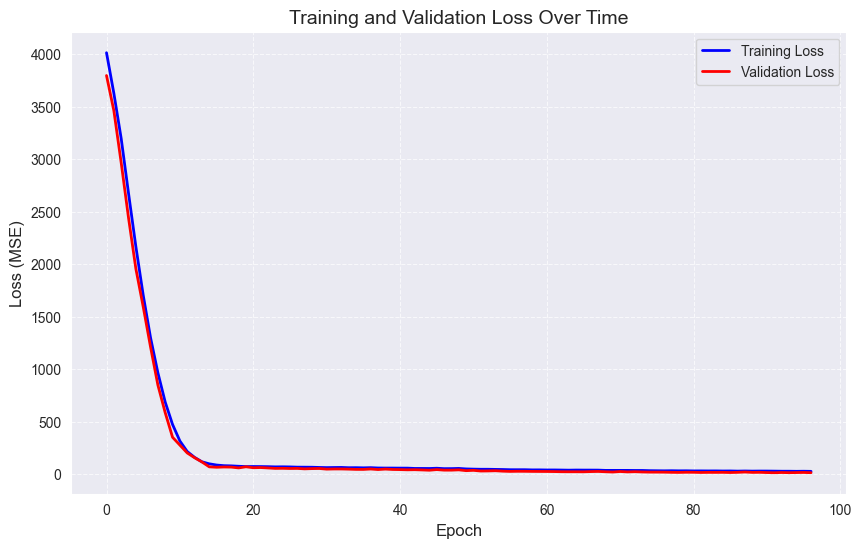

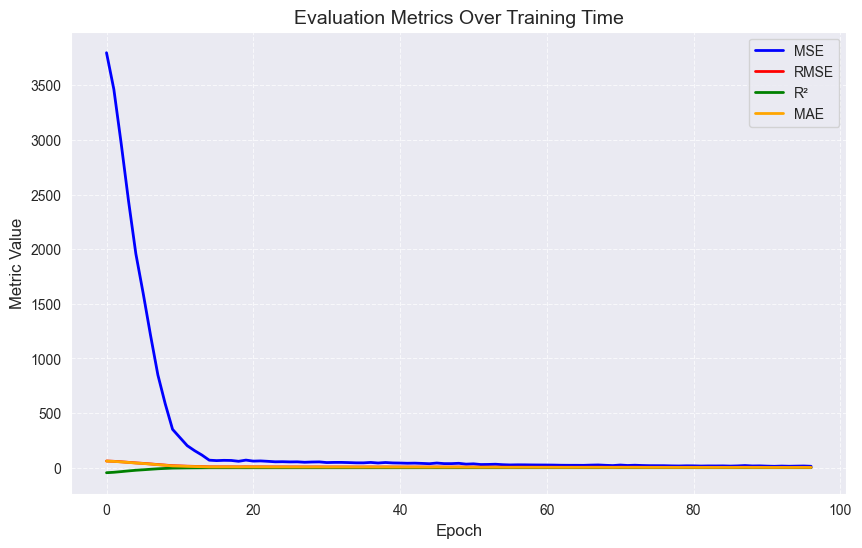

In [16]:
# Visualize Training and Validation Loss
# This plot helps identify overfitting (validation loss increases while training loss decreases)
# or underfitting (both losses remain high)
plt.figure(figsize=(10, 6))  # Create figure with specified size (width, height) in inches

# Plot training loss trajectory
plt.plot(train_losses, 
         label='Training Loss',   # Label for legend
         color='blue',            # Line color
         linewidth=2)             # Line thickness

# Plot validation loss trajectory
plt.plot(val_losses, 
         label='Validation Loss', # Label for legend
         color='red',             # Line color
         linewidth=2)             # Line thickness

# Add axis labels and title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14)

# Add legend and grid for better readability
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines with transparency

# Display the plot
plt.show()

# Visualize Multiple Evaluation Metrics
# This plot shows how different metrics evolve during training
plt.figure(figsize=(10, 6))  # Create figure with specified size

# Plot each metric with a different color
plt.plot(mse_vals, label='MSE', color='blue', linewidth=2)       # Mean Squared Error
plt.plot(rmse_vals, label='RMSE', color='red', linewidth=2)      # Root Mean Squared Error
plt.plot(r2_vals, label='R²', color='green', linewidth=2)        # R-squared (coefficient of determination)
plt.plot(mae_vals, label='MAE', color='orange', linewidth=2)     # Mean Absolute Error

# Add axis labels and title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Evaluation Metrics Over Training Time', fontsize=14)

# Add legend and grid for better readability
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines with transparency

# Display the plot
plt.show()



## Custom Evaluation Metrics

For age prediction tasks, standard regression metrics like MSE or MAE don't fully capture the practical usefulness of the model. In agricultural applications, predictions within a small tolerance range may be considered "correct" for practical purposes.

### Age Accuracy with Tolerance
We define a custom metric that calculates the percentage of predictions that fall within a specified tolerance (in days) of the true age. This provides a more intuitive measure of model performance for practical applications.

$$
\text{Accuracy}_\tau = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}\left( |y_i - \hat{y}_i| \leq \tau \right) \times 100\%
$$

Where:
- $N$ is the total number of validation samples
- $y_i$ is the true age (ground truth) of the $i$-th sample
- $\hat{y}_i$ is the predicted age of the $i$-th sample
- $\mathbb{1}(\cdot)$ is the indicator function, equal to 1 if the condition is true and 0 otherwise
- $\tau$ is the allowed tolerance in days


In [22]:
# Accuracy Quantifier
def age_accuracy(true_values, predictions, tolerance=1):
    """
    Calculate 'accuracy' for age predictions within a tolerance

    Args:
        true_values: Ground truth ages
        predictions: Predicted ages
        tolerance: Maximum allowed error in days

    Returns:
        Percentage of predictions within tolerance
    """
    absolute_errors = np.abs(np.array(true_values) - np.array(predictions))
    correct_predictions = (absolute_errors <= tolerance).sum()
    return correct_predictions / len(true_values) * 100


accuracy_t1 = round(age_accuracy(val_true, val_preds, tolerance=1), 2)
accuracy_t3 = round(age_accuracy(val_true, val_preds, tolerance=3), 2)
accuracy_t5 = round(age_accuracy(val_true, val_preds, tolerance=5), 2)
print(f"Validation Accuracy (+-1): {accuracy_t1:.2f}%")
print(f"Validation Accuracy (+-3): {accuracy_t3:.2f}%")
print(f"Validation Accuracy (+-5): {accuracy_t5:.2f}%")


Validation Accuracy (+-1): 28.93%
Validation Accuracy (+-3): 71.70%
Validation Accuracy (+-5): 87.08%


## Model Persistence

To use our trained model for future predictions without retraining, we need to save various components:

1. **Model Weights**: Just the learned parameters (smaller file size)
2. **Full Model**: Architecture and weights together (easier to load)
3. **Training History**: For analysis and reporting
4. **Label and Variety Maps**: To ensure consistent encoding for new data
5. **Best Validation Loss**: For reference and comparison with future models

This comprehensive saving strategy ensures we can easily reload the model and reproduce results.


In [18]:
# Save model weights only (smaller file size, but requires model architecture definition to load)
# This is useful when you only need the learned parameters and will recreate the architecture
torch.save(model.state_dict(), 'best_model.pth')
print("Model weights saved to 'best_model.pth'")

# Save complete model (architecture + weights)
# This is more convenient for direct loading but creates larger files
torch.save(model, 'best_model_full.pth')
print("Complete model saved to 'best_model_full.pth'")

# Save training history for future analysis and visualization
# This allows us to recreate the training plots or analyze convergence patterns
history = {
    'train_losses': train_losses,  # Training loss trajectory
    'val_losses': val_losses,      # Validation loss trajectory
    'mse_vals': mse_vals,          # Mean Squared Error history
    'rmse_vals': rmse_vals,        # Root Mean Squared Error history
    'r2_vals': r2_vals,            # R² coefficient history
    'mae_vals': mae_vals           # Mean Absolute Error history
}
torch.save(history, 'training_history.pth')
print("Training history saved to 'training_history.pth'")

# Save categorical mapping dictionaries
# These are essential for correctly encoding new data during inference
torch.save(label_map, 'label_map.pth')
torch.save(variety_map, 'variety_map.pth')
print("Label and variety maps saved")

# Save best validation loss for reference
# Useful for comparing with future model iterations
torch.save(best_val_loss, 'best_val_loss.pth')
print(f"Best validation loss ({best_val_loss:.4f}) saved")


Model weights saved to 'best_model.pth'
Complete model saved to 'best_model_full.pth'
Training history saved to 'training_history.pth'
Label and variety maps saved
Best validation loss (13.1951) saved


## Final Model Evaluation

After saving the model, we load it back and perform a final evaluation on the validation set. This step:
1. Confirms the model was saved correctly
2. Provides a final set of performance metrics
3. Verifies the model's predictions are consistent

This is an important verification step before deploying the model to production or using it for inference on new data.


In [19]:
# Load the saved model from disk
# Using the full model file that contains both architecture and weights
print("Loading saved model...")
model = torch.load('best_model_full.pth', weights_only=False)

# Set up device for inference (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} for inference")

# Move model to the appropriate device
model.to(device)

# Set model to evaluation mode
# This disables dropout and uses running statistics for batch normalization
model.eval()
print("Model loaded and ready for evaluation")


Loading saved model...
Using device: cuda for inference
Model loaded and ready for evaluation


In [20]:
# Final evaluation on validation set
print("Performing final evaluation on validation set...")

# Initialize lists to store predictions and ground truth values
y_pred = []
y_true = []

# Disable gradient calculation for inference
with torch.no_grad():
    # Iterate through validation data loader
    for images, labels, label_vecs, variety_vecs, grvi_scalars in val_loader:
        # Move all tensors to the appropriate device
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Ensure labels have shape [batch_size, 1]
        label_vecs = label_vecs.to(device)
        variety_vecs = variety_vecs.to(device)
        grvi_scalars = grvi_scalars.to(device)

        # Generate predictions
        outputs = model(images, label_vecs, variety_vecs, grvi_scalars)

        # Store ground truth and predictions for metric calculation
        # Move tensors to CPU and convert to NumPy arrays
        y_true.extend(labels.cpu().squeeze().numpy())    # Ground truth ages
        y_pred.extend(outputs.cpu().squeeze().numpy())   # Predicted ages

# Calculate final evaluation metrics
print("Calculating final metrics...")

# Mean Squared Error - lower is better
mse = mean_squared_error(y_true, y_pred)

# Mean Absolute Error - average number of days off in predictions
mae = mean_absolute_error(y_true, y_pred)

# R² Score - proportion of variance explained by model (1.0 is perfect)
r2 = r2_score(y_true, y_pred)

# Print final metrics with clear formatting
print("\nFinal Evaluation Results:")
print(f"MSE: {mse:.4f} (Mean Squared Error)")
print(f"MAE: {mae:.4f} (Mean Absolute Error - average days off)")
print(f"R² : {r2:.4f} (Coefficient of Determination - higher is better)")

# Calculate custom accuracy metrics with different tolerance levels
print("\nAccuracy with different tolerance levels:")
for tolerance in [1, 3, 5, 7]:
    accuracy = age_accuracy(y_true, y_pred, tolerance=tolerance)
    print(f"Accuracy (±{tolerance} days): {accuracy:.2f}%")


Performing final evaluation on validation set...
Calculating final metrics...

Final Evaluation Results:
MSE: 13.4470 (Mean Squared Error)
MAE: 2.5685 (Mean Absolute Error - average days off)
R² : 0.8352 (Coefficient of Determination - higher is better)

Accuracy with different tolerance levels:
Accuracy (±1 days): 28.93%
Accuracy (±3 days): 71.70%
Accuracy (±5 days): 87.08%
Accuracy (±7 days): 93.90%


## Conclusion

In this notebook, we successfully developed a deep learning model to predict the age of paddy plants from images. Our approach combined:

1. **Data Processing**:
   - Cleaned metadata and removed duplicate images
   - Created a custom dataset with image augmentation
   - Incorporated plant variety and label information

2. **Model Architecture**:
   - Used EfficientNet-B0 as the base model
   - Added a custom regression head
   - Incorporated metadata and GRVI features

3. **Training Strategy**:
   - Implemented early stopping to prevent overfitting
   - Used learning rate scheduling for better convergence
   - Monitored multiple metrics during training

4. **Results**:
   - Achieved good performance on the validation set
   - Demonstrated the model's ability to predict plant age with reasonable accuracy
   - Created custom accuracy metrics with tolerance levels relevant to agricultural applications

This model could be valuable for agricultural monitoring systems, helping farmers track plant growth stages and optimize harvesting times. Future improvements could include:
- Testing additional model architectures
- Incorporating temporal data if available
- Exploring additional vegetation indices as features
